In [391]:
# Import Libraries
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import pyspark as ps    # for the pyspark suitefrom collections import Counter
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use('ggplot')

In [672]:
# Import Custom Modules
from src.eda_helper import *

In [93]:
# Create spark session
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("capstone1") \
            .getOrCreate()
sc = spark.sparkContext

In [542]:
ls data/


AMAZON_FASHION_5.json  All_Beauty_5.json      Books_5.json


## Explore data in Beauty

In [560]:
# beauty ratings
path_beauty = "data/All_Beauty_5.json"


In [6]:
# Create Spark DF
beauty_df = spark.read.json(path_beauty)
# Create Spark SQL
beauty_df.createOrReplaceTempView('beauty')
# Create Spark RDD
beauty_rdd = sc.textFile(path_beauty)

In [7]:
beauty_df.printSchema()

print(beauty_df.count())

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Design:: string (nullable = true)
 |    |-- Flavor:: string (nullable = true)
 |    |-- Scent Name:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)

5269


In [8]:
beauty_rdd.take(1)

['{"overall": 5.0, "verified": true, "reviewTime": "09 1, 2016", "reviewerID": "A3CIUOJXQ5VDQ2", "asin": "B0000530HU", "style": {"Size:": " 7.0 oz", "Flavor:": " Classic Ice Blue"}, "reviewerName": "Shelly F", "reviewText": "As advertised. Reasonably priced", "summary": "Five Stars", "unixReviewTime": 1472688000}']

## Clean data


In [635]:
path_dict = {'beauty':"data/All_Beauty_5.json",'books':"data/Books_5.json"}

In [636]:
# read data , 
# call function to Map each RDD item to JSON,
# filter the ratings that is not verified
# return a dataframe that contains year, ratings, and category name.

def read_data(path,name):
    rdd      = sc.textFile(path)
    rdd_json = map_to_json(rdd)
    df       = clean_data(rdd_json,name)
    return df

In [642]:
#create  ratings dataframes in Beauty and Books
ratings_beauty = read_data(path_dict['beauty'],'beauty')
ratings_books  = read_data(path_dict['books'],'books')


In [711]:
## Sample View
print("ratings count in beauty: ",ratings_beauty.ratings.count())
ratings_beauty.head(10)

ratings count in beauty:  4280


,ratings,years,category
0,5.0,2016,beauty
1,5.0,2013,beauty
2,1.0,2013,beauty
3,5.0,2011,beauty
4,2.0,2018,beauty
5,1.0,2018,beauty
6,1.0,2018,beauty
7,1.0,2018,beauty
8,1.0,2018,beauty
9,1.0,2018,beauty


In [ ]:
## Sample View
print("ratings count in books: ",ratings_books.ratings.count())
ratings_books.head(3)

## Calculate the average ratings and standard deviation by year


In [707]:
#call eda_helper.avg_by_year function to 
#create a dataframe that containt mean and std of ratings by year
avg_by_year_beauty = avg_by_year(ratings_beauty)
avg_by_year_books = avg_by_year(ratings_books)
# avg_by_year_books

In [709]:
## merge two dataframes above
by_year_merge = pd.merge(avg_by_year_beauty,avg_by_year_books, how = 'outer',on=['year']) 

# rename columns
by_year_merge = by_year_merge.rename(columns = {'avg_ratings_x': 'avg_beauty',
                                                  'std_x':         'std_beauty',
                                                 'avg_ratings_y':  'avg_books',
                                                  'std_y':         'std_books',
                                                 })
# # avg_year_merge = avg_year_merge.replace(np.nan, 0)
by_year_merge = by_year_merge.sort_values(by = 'year').reset_index(drop = True)
by_year_merge.tail(3)

,year,avg_beauty,std_beauty,avg_books,std_books
19,2016,4.940147,0.280075,4.455942,0.944345
20,2017,4.939571,0.303388,4.482515,0.935480
21,2018,3.448468,1.789788,4.506975,0.925540


### merge mean, std from two categoris

In [649]:
df_list   = [ratings_beauty,ratings_books]
mean_list =[ratings_mean(df) for df in df_list]
std_list  =[ratings_std(df) for df in df_list]
cotegories = list(path_dict.keys())
print(mean_list,std_list,labels)

[4.8143, 4.4258] [0.7305, 0.9661] ['beauty', 'books', 'fashion']


In [650]:
ave_ratings_merge = pd.DataFrame({'mean':mean_list,
                                   'std':std_list},
                                index = cotegories
                                 )
ave_ratings_merge

,mean,std
beauty,4.8143,0.7305
books,4.4258,0.9661


## Vasualize the data 

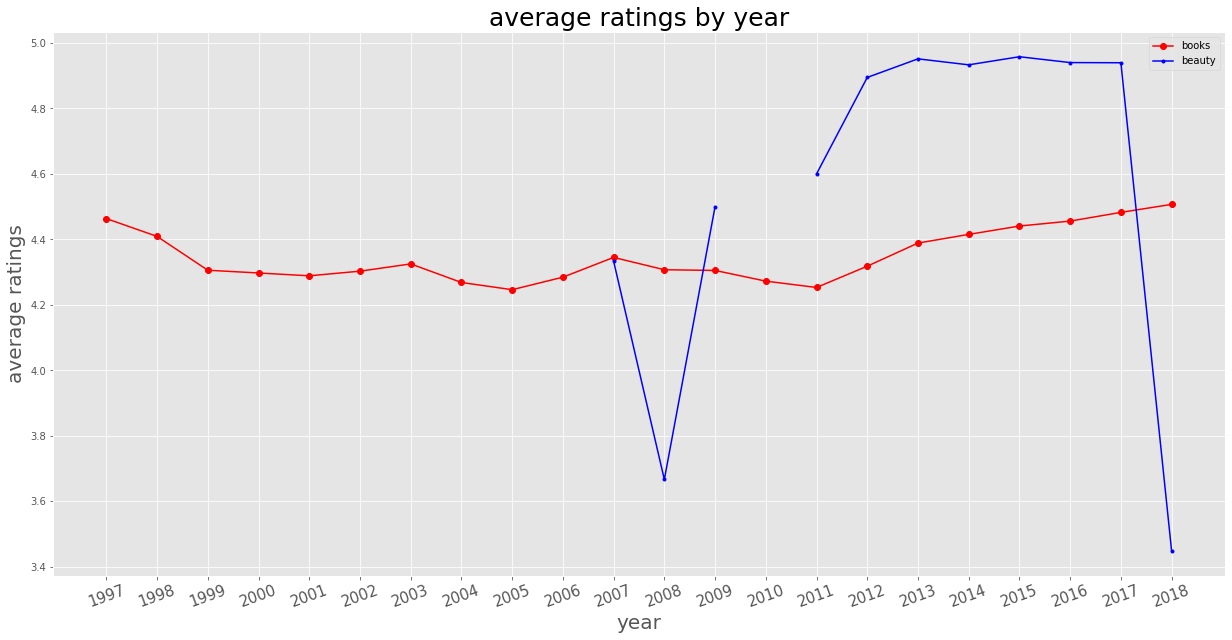

In [703]:
#plot the average ratings by year
fig, ax = plt.subplots(figsize=(21,10))
x = np.arange(len(by_year_merge['year']))
labels = avg_year_merge['year'].tolist()
ax.plot(x, by_year_merge['avg_books'],'o-',color='r',label = 'books')
ax.plot(x, by_year_merge['avg_beauty'],'.-',color='b',label = 'beauty')
ax.set_xlabel("year",fontsize=20)
ax.set_ylabel("average ratings",fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=15,rotation=20)
ax.set_title('average ratings by year',fontsize=25)
ax.legend()
plt.savefig('images/average_ratings_plot.png')

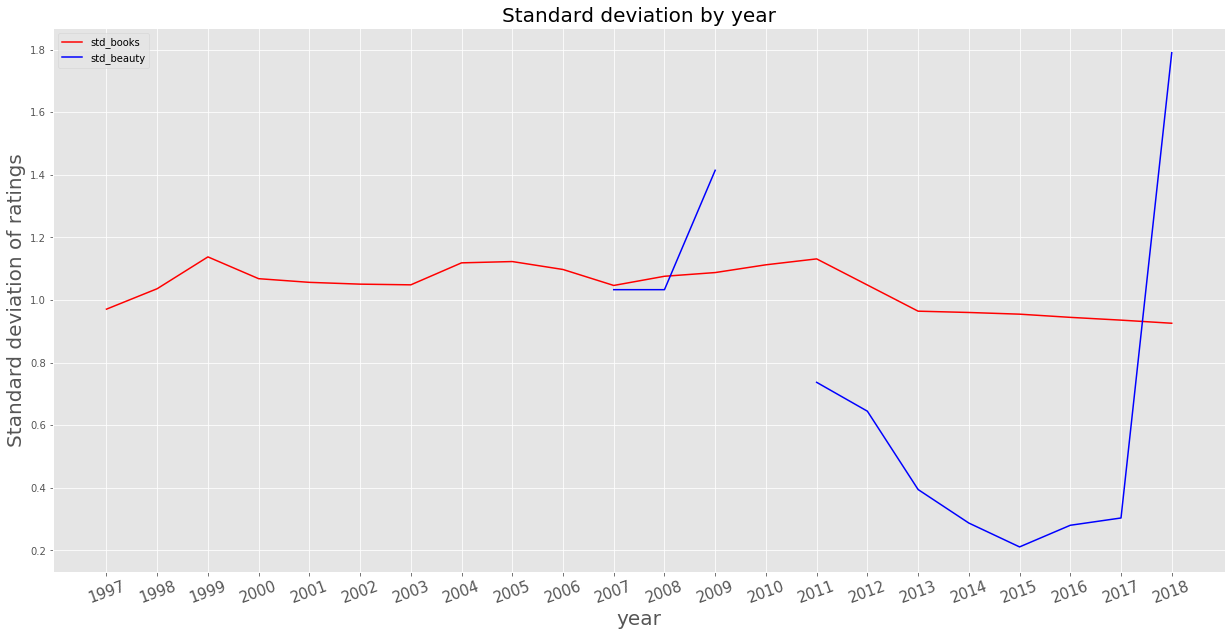

In [704]:
#plot the average ratings by year
fig, ax = plt.subplots(figsize=(21,10))
ax.plot(x, by_year_merge['std_books'],color='r',label = 'std_books')
ax.plot(x, by_year_merge['std_beauty'],color='b',label = 'std_beauty')
ax.set_xlabel("year",fontsize=20)
ax.set_ylabel("Standard deviation of ratings",fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=15,rotation=20)
ax.set_title("Standard deviation by year",fontsize=20)
ax.legend()
plt.savefig('images/standard_deviaton_plot.png')

### ratings distribution in Beauty

Text(0.5, 1.0, 'Distribution of ratings in Beauty')

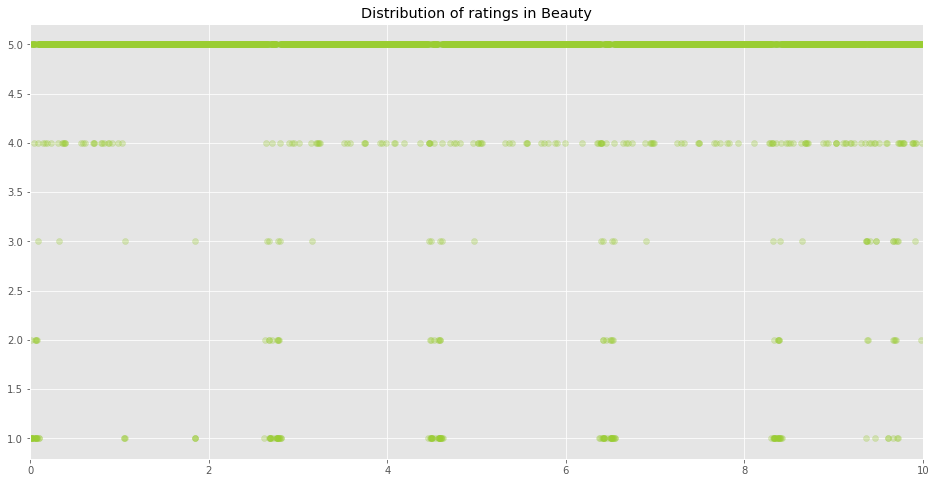

In [706]:
fig, ax = plt.subplots(1, figsize=(16, 8))

x = np.linspace(0, 10, num=len(ratings_beauty['ratings']))
ax.scatter(x, ratings_beauty['ratings'], color='yellowgreen',alpha=0.3)
ax.set_xlim(0, 10)
ax.set_title("Distribution of ratings in Beauty")


In [731]:
bins = [1,2,3,4,5]
cnt_beauty = Counter(ratings_beauty['ratings'].values)
cnt_books = Counter(ratings_books['ratings'].values)
list(cnt_books.keys())

[5.0, 2.0, 4.0, 1.0, 3.0, 0.0]

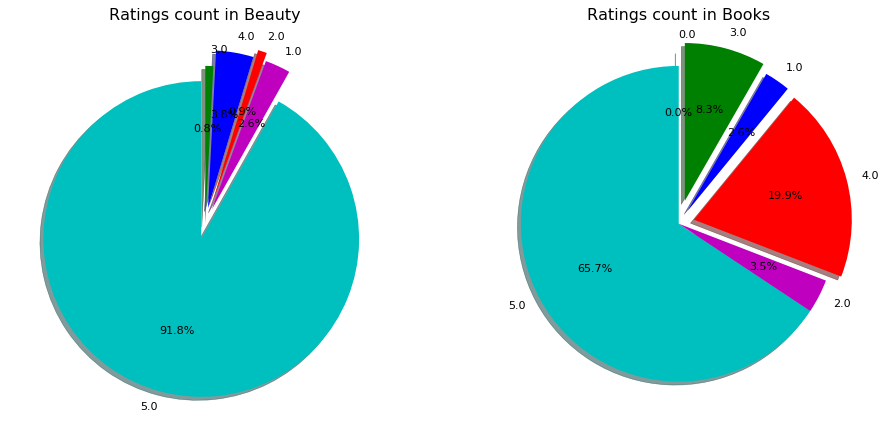

In [732]:
fig, axs = plt.subplots(1,2,figsize=(14, 10), dpi=80)
labels = list(cnt_beauty.keys())
sizes  = list(cnt_beauty.values())
cols = ['c','m','r','b','g']
axs[0].pie(sizes,
        labels=labels,
        startangle=90,
        shadow= True,
        colors=cols,
        explode=(0.1,0.1,0.15,0.1,0),
        autopct='%1.1f%%')
axs[0].set_title("Ratings count in Beauty")

labels1 = list(cnt_books.keys())
sizes1  = list(cnt_books.values())
cols1 = ['c','m','r','b','g']
axs[1].pie(sizes1,
        labels=labels1,
        startangle=90,
        shadow= True,
        colors=cols1,
        explode=(0,0,0.1,0.1,0.15,0.1),
        autopct='%1.1f%%')
axs[1].set_title("Ratings count in Books")

plt.savefig('images/ratings_count.png')


## A/B testing

### using Welch's t-test

### The average ratings from 2007 to 2018 between Beauty and  Books.

In [430]:
# H0: There is no difference in the average ratings of Beauty and Books.
# H1: The average ratings of Beauty and Books are different
# alpha: 0.01

In [710]:
ratings_ttest_all = stats.ttest_ind(ratings_beauty.ratings,ratings_books.ratings)
print(ratings_ttest_all)

Ttest_indResult(statistic=26.298851566856253, pvalue=1.9895758749664697e-152)


In [ ]:
# p-value is small than alpha, there are enough advience to reject H0.
# The average ratings of Beauty and Books are different.

In [514]:
ratings_ttest_2018 = stats.ttest_ind(ratings_beauty_2018.ratings,
                                     After_2007_books.ratings)
print(ratings_ttest_2018)

Ttest_indResult(statistic=-19.222115304892696, pvalue=2.4216966678744823e-82)


In [504]:
ratings_beauty_2018 = ratings_beauty[ratings_beauty['years']==2018]
ratings_beauty_2018 = ratings_beauty_2018.reset_index(drop =True)
ratings_beauty_2018.head(5)

,ratings,years
0,2.0,2018
1,1.0,2018
2,1.0,2018
3,1.0,2018
4,1.0,2018


In [508]:
After_2007_books.tail(2)

,ratings,years
18152305,5.0,2016
18152306,5.0,2016


In [512]:
ratings_books_2018 = After_2007_books[After_2007_books['years']==2018]
ratings_books_2018 = ratings_books_2018.reset_index(drop =True)
ratings_books_2018.head(5)

,ratings,years
0,4.0,2018
1,5.0,2018
2,5.0,2018
3,5.0,2018
4,5.0,2018


In [ ]:
After_2007 = 